<a href="https://colab.research.google.com/github/vmazashvili/Neural-Networks/blob/main/MaskTune_Vano_Mazashvili_1993251.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Masktune

Masktune is a single-epoch finetuning technique that prevents a model from learning only the "first" simplest mapping (potentially spurious correlations) from the input to the corresponding target variable. It forces the model to explore other train variables by concealing the first explored ones, causing the training to escape its myopic and greedy feature-seeking approach and encourage exploring and leveraging more input variables.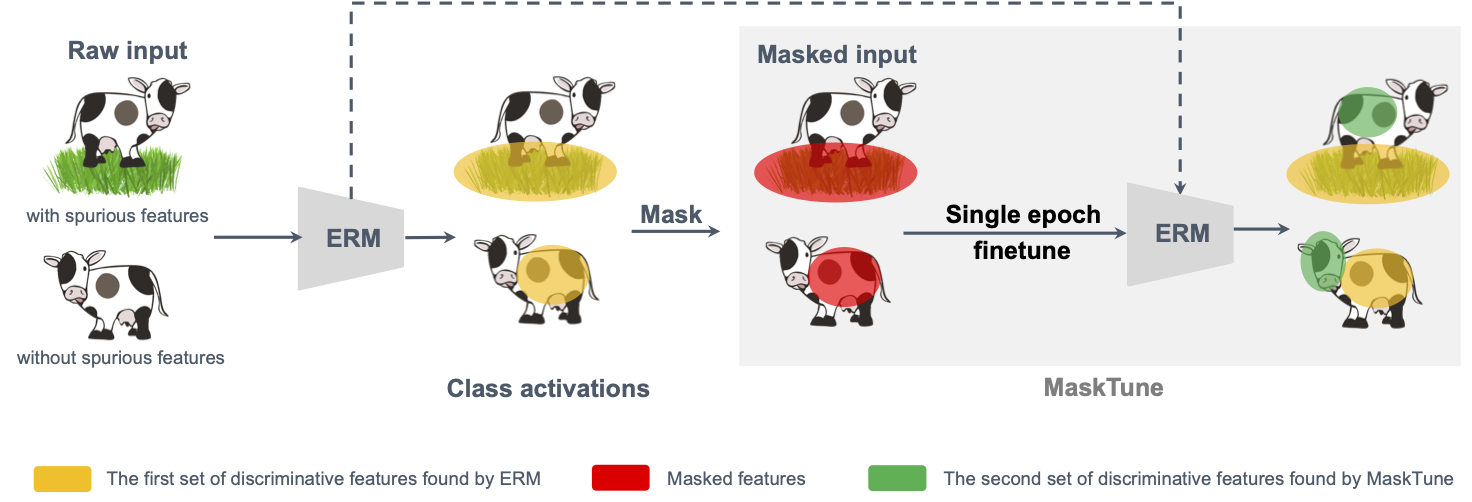

Project outline:

1.   **Train the model using** Empirical Risk Minimization (**ERM**)


2.  After the initial training with the empirical risk minimization, we can apply Masktune, which incorporates:

    - **Database masking** - identifying and masking the most influential, potentially spurious features
        1.  **Identify the spurious features** / class activations from saliency maps. In case of present spurious features, the method will likely identify the spurious feature, while for the input without any spurious features, the function will identify the most prominent features to mask, forcing the training to escape its myopic and greedy feature-seeking approach and encouraging and leveraging more input variables [1]

        2.  **Generate masks** to cover the most discriminatory features discovered in the saliency maps.

    - **Mask Application** -  masked data will force the model to explore less prominent and potentially more descriptive non-spurious features.

3.  The generated masks from the step 3 will be applied to the dataset
5.  We will **fine-tune** the pretrained ERM model on newly masked dataset only for one epoch.



### Dependencies

In [1]:
!pip install torch torchvision timm
!pip install torchcam
!pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [2]:
import os
import cv2
#import timm
import torch
import random
import numpy as np
import torchvision
from torch.optim import SGD
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.nn import CrossEntropyLoss
from torchcam.methods import XGradCAM
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
from torchvision.transforms.functional import resize
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

## MNIST DATASET

We will be implementing the method on MNIST dataset. The procedure is the following:
- [x] Distinguish between two MNIST digit groups (0-4 and 5-9)
- [x] 0-4 into class 0 and 5-9 into class 1.
- [x] Transform 99% of new class 0 and 1% of the new class 1 so that they acquire same spurious feature (square in top left corner)
- [x] Two test sets during testing: the original raw MNIST test set and a biased test set.
- [x] biasd test set - add spurious feature to only 5-9 group  

### Step 1: Remap the dataset

After downloading and normalizing the MNIST training and test datasets using torchvision, we:

Remap the 10 classes (0-9) to 2 (0, 1).

Digits 0-5 are labeled with class 0, digits 5-9 are labeled with class 1.

The remapped classes are saved into `remapped_train_data` and `remapped_test_data` lists.

Each element is `(PIL.Image.Image instance, class_label)`

In [3]:
import torch
from torchvision import datasets

def remap_classes(dataset):
    """
    Remap MNIST dataset classes to two new classes
    new_to_old_label_mapping={0: [0, 1, 2, 3, 4], 1: [5, 6, 7, 8, 9]},

    Input:
        MNIST dataset

    Output:
        List of remapped dataset. Each item is (PIL image, class)
    """
    remapped_data = []
    remapped_targets = []

    for data, target in dataset:
        if target < 5:  # Digits 0-4
            remapped_targets.append(0)
        else:  # Digits 5-9
            remapped_targets.append(1)

        remapped_data.append(data)

    return list(zip(remapped_data, remapped_targets))

# Load the MNIST dataset
mnist_train = datasets.MNIST(root='data', train=True, download=True)
mnist_test = datasets.MNIST(root='data', train=False, download=True)

# Remap the classes, the variables contain lists:
remapped_train_data = remap_classes(mnist_train)
remapped_test_data = remap_classes(mnist_test)

print("Original class distribution in train set:", mnist_train.targets.bincount())
print("Remapped class distribution in train set:", torch.tensor([target for _, target in remapped_train_data]).bincount())

print("Original class distribution in test set:", mnist_test.targets.bincount())
print("Remapped class distribution in test set:", torch.tensor([target for _, target in remapped_test_data]).bincount())


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 43499930.68it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1151961.79it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9614164.29it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7712764.68it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Original class distribution in train set: tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])
Remapped class distribution in train set: tensor([30596, 29404])
Original class distribution in test set: tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])
Remapped class distribution in test set: tensor([5139, 4861])


Check the first element of the list

In [4]:
remapped_train_data[0]

(<PIL.Image.Image image mode=L size=28x28>, 1)

### Step 2: Add Spurious Features to the Dataset

Apply spurious feature, a blue square in the top left corner of the image, to the 99% of samples of class 0, and 1% of class 1 in `remapped_train_data` list of tuples.

The results are saved in `train_data_spuriousus` list of tuples.

The images are transformed from grayscale to RGB, for the proper implementation of the blue spurious feature.


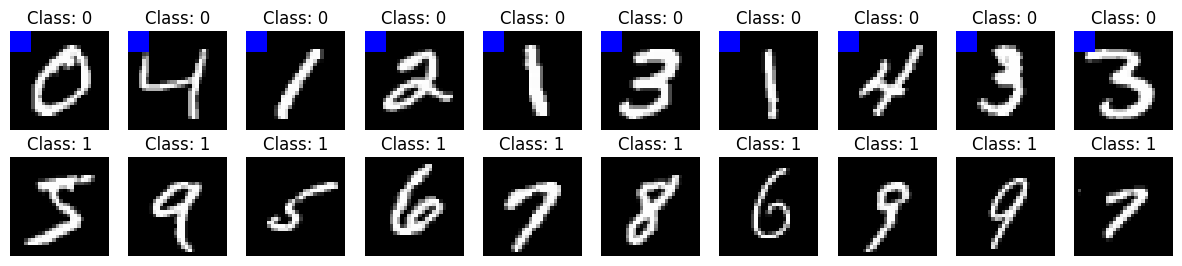

In [5]:
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def add_spurious_feature(image, label, percentage_class_0=0.99, percentage_class_1=0.01):
    """
    A function to add blue spurious features to PIL images based on class-specific percentages.

    Args:
        image (PIL.Image.Image): Input image.
        label (int): The class label of the image.
        percentage_class_0 (float, optional): Percentage of class 0 samples to apply the feature to. Defaults to 0.99.
        percentage_class_1 (float, optional): Percentage of class 1 samples to apply the feature to. Defaults to 0.01.

    Returns:
        PIL.Image.Image: Transformed image with the spurious feature.
    """
    # Determine the appropriate percentage based on the class label
    percentage = percentage_class_0 if label == 0 else percentage_class_1

    # Check if the condition for adding the feature is met
    if random.random() < percentage:
        # Create a copy of the input image
        image_with_spurious = image.convert("RGB")  # Ensure the image is in RGB mode
        # Create a drawing context, image should be already in RGB, so no need to specify with the argument
        draw = ImageDraw.Draw(image_with_spurious)
        # Draw a blue square in the top-left corner
        draw.rectangle([0, 0, 5, 5], fill=(0, 0, 255))  # Blue color
        del draw  # Release drawing context
        return image_with_spurious
    else:
        return image.convert("RGB")  # Ensure the image is in RGB

# Apply add_spurious_feature to the entire remapped_train_data dataset
train_data_spurious = [(add_spurious_feature(image, label), label) for image, label in remapped_train_data]

# Display 10 samples from each class
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
class_0_count = 0
class_1_count = 0

for image, label in train_data_spurious:
    if label == 0 and class_0_count < 10:
        axes[0, class_0_count].imshow(image)
        axes[0, class_0_count].set_title(f"Class: {label}")
        axes[0, class_0_count].axis('off')
        class_0_count += 1
    elif label == 1 and class_1_count < 10:
        axes[1, class_1_count].imshow(image)
        axes[1, class_1_count].set_title(f"Class: {label}")
        axes[1, class_1_count].axis('off')
        class_1_count += 1

    if class_0_count >= 10 and class_1_count >= 10:
        break

plt.show()


Copy `remapped_test_data` to `test_data_raw`, so that we can modify the original test dataset and save it in `test_data_spurious`. Both of them are lists of tuples of PIL images and class labels.

In this way, we are able to test the trained model on both, original and the biased test datasets.

The `test_data_spurious` has each sample of class 1 modified with the spurious feature.


In [6]:
import random
from PIL import Image, ImageDraw

def add_spurious_feature_test(image, label, spurious_value=(0, 0, 255)):
    """
    A function to add a blue spurious feature to a PIL image for class 1 samples.

    Args:
        image (PIL.Image.Image): Input image.
        label (int): The class label of the image.
        spurious_value (tuple, optional): RGB value to assign to the spurious feature pixels. Defaults to blue (0, 0, 255).

    Returns:
        PIL.Image.Image: Transformed image with the spurious feature added (if applicable).
    """
    if label == 1:
        # Always add the feature to class 1 samples
        image_with_spurious = image.convert("RGB")  # Ensure the image is in RGB mode
        draw = ImageDraw.Draw(image_with_spurious)
        draw.rectangle([0, 0, 5, 5], fill=spurious_value)
        del draw
        return image_with_spurious
    else:
        return image.convert("RGB")  # Ensure the image is in RGB mode

# Save remapped_test_data into test_data_raw
test_data_raw = remapped_test_data.copy()  # Create a copy to avoid modifying the original data

# Create a copy to avoid modifying the original data
test_data_raw = remapped_test_data.copy()

# Loop through each image and label in test_data_raw
for i, (image, label) in enumerate(test_data_raw):
  # Convert the image to RGB format
  image = image.convert("RGB")

  # Update the test_data_raw list with the converted image
  test_data_raw[i] = (image, label)

# Apply spurious features to class 1 samples in test_data_raw and store in test_data_spurious
test_data_spurious = [(add_spurious_feature_test(image, label), label) for image, label in remapped_test_data]

Display 10 samples for `test_data_raw` and `test_data_spurious`.

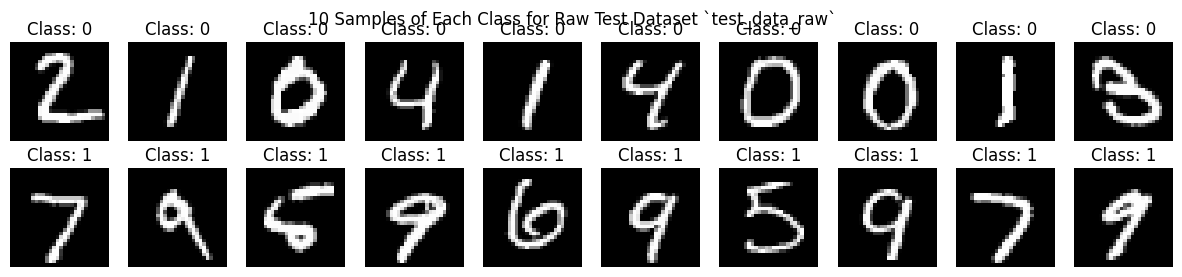

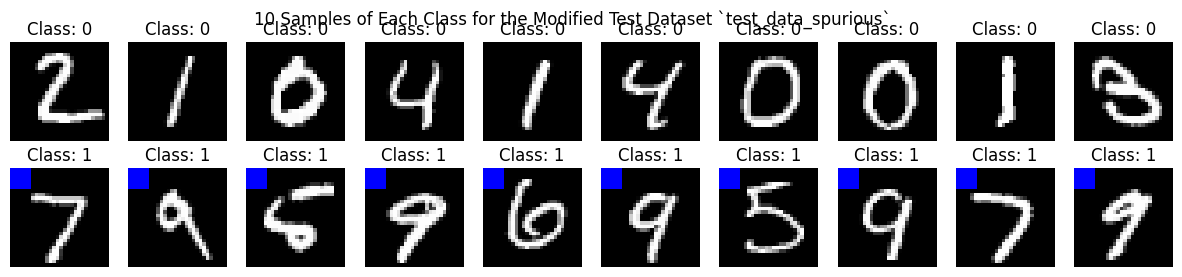

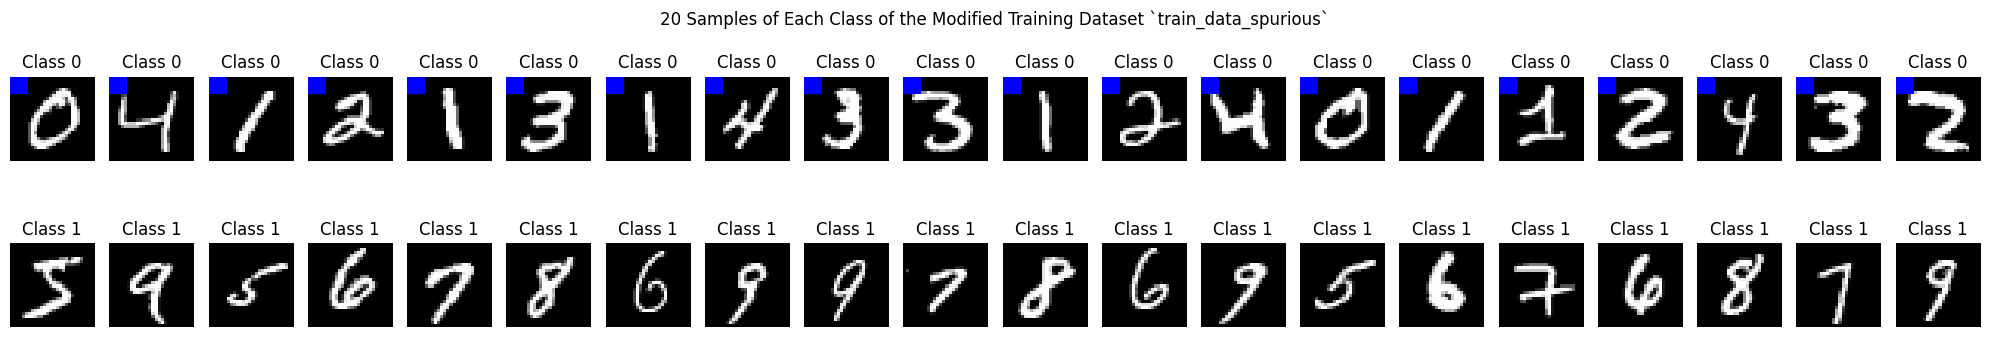

(<PIL.Image.Image image mode=RGB size=28x28>, 1)

In [7]:
# Display 10 samples from each class in the raw test set
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
class_0_count = 0
class_1_count = 0

for image, label in test_data_raw:
    if label == 0 and class_0_count < 10:
        axes[0, class_0_count].imshow(image)
        axes[0, class_0_count].set_title(f"Class: {label}")
        axes[0, class_0_count].axis('off')
        class_0_count += 1
    elif label == 1 and class_1_count < 10:
        axes[1, class_1_count].imshow(image)
        axes[1, class_1_count].set_title(f"Class: {label}")
        axes[1, class_1_count].axis('off')
        class_1_count += 1

    if class_0_count >= 10 and class_1_count >= 10:
        break

plt.suptitle("10 Samples of Each Class for Raw Test Dataset `test_data_raw`", fontsize=12)  # Add main title
plt.show()

# Display 10 samples from each class in the biased test set
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
class_0_count = 0
class_1_count = 0

for image, label in test_data_spurious:
    if label == 0 and class_0_count < 10:
        axes[0, class_0_count].imshow(image)
        axes[0, class_0_count].set_title(f"Class: {label}")
        axes[0, class_0_count].axis('off')
        class_0_count += 1
    elif label == 1 and class_1_count < 10:
        axes[1, class_1_count].imshow(image)
        axes[1, class_1_count].set_title(f"Class: {label}")
        axes[1, class_1_count].axis('off')
        class_1_count += 1

    if class_0_count >= 10 and class_1_count >= 10:
        break

plt.suptitle("10 Samples of Each Class for the Modified Test Dataset `test_data_spurious`", fontsize=12)  # Add main title
plt.show()

# Initialize counters for each class
class_counts = {0: 0, 1: 0}

# Plot 10 samples for each class
fig, axes = plt.subplots(2, 20, figsize=(20, 4))

for image, label in train_data_spurious:
    # Check if the maximum number of samples for each class is reached
    if class_counts[label] >= 20:
        continue

    # Plot the image
    ax = axes[label][class_counts[label]]
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Class {label}')

    # Increment the counter for the respective class
    class_counts[label] += 1

plt.tight_layout()
plt.suptitle("20 Samples of Each Class of the Modified Training Dataset `train_data_spurious`", fontsize=12)  # Add main title
plt.show()


# Accessing first elements (assuming these are iterables)
train_data_spurious[0]
remapped_test_data[0]
test_data_spurious[0]


Therefore, we should have a training dataset ```train_data_spurious``` with two classes, 0 (containing digits 0-4) and 1 (digits 5-9).
99% of the samples in class 0 have a spurious feature, while 1% of the class 1 has the same spurious feature.

As for testing dataset, we have 2, ```test_data_raw``` and ```test_data_spurious```. One will be a raw MNIST test dataset, while the other one will be a modified one with spurious features for class 1 samples.

Thus we have ```test_data_daw```, ```test_data_spurious``` with only class 1 sample spurious features, `train_data_spurious`, and `remapped_train_data`

### Step 3: Create dataloaders
From the created lists in step 1, we make batches with a size of 128.

`transforms.ToTensor()` is applied to the PIL images in the dataset for simpler implementation.

Which leaves us with the dataloaders containing the tuples of the sample tensor and its class label, with a batch size of 128.

In this step, the RGB feature of the images is ensured. This way, the tensors with the size of `[3, 28, 28]`, instead of `[1, 28, 28]` can be properly fed to the CNN provided in the paper.

This gives us the dataloaders with the dimensions of `[128, 3, 28, 28]`.

In [8]:
from PIL import Image

# Convert grayscale images in remapped_test_data to RGB
remapped_train_data = [(image.convert("RGB"), label) for image, label in remapped_train_data]

# Define a transform to convert PIL images to tensors
transform = transforms.ToTensor()

train_data_spurious_tensor = [(transform(image), label) for image, label in train_data_spurious]

test_data_spurious_tensor = [(transform(image), label) for image, label in test_data_spurious]

test_data_raw_tensor = [(transform(image), label) for image, label in test_data_raw]


In [9]:
train_spurious_dataloader = DataLoader(train_data_spurious_tensor, batch_size=128)
test_raw_dataloader = DataLoader(test_data_raw_tensor, batch_size=128)
test_spurious_dataloader = DataLoader(test_data_spurious_tensor, batch_size=128)

len(train_spurious_dataloader)
len(test_raw_dataloader)
len(test_spurious_dataloader)

for data_batch, label_batch in train_spurious_dataloader:
    print("Data batch shape:", data_batch.shape)
    print("Label batch shape:", label_batch.shape)
    print("Data batch example:", data_batch[0])
    print("Label batch example:", label_batch[0])
    break  # Only print the first batch


Data batch shape: torch.Size([128, 3, 28, 28])
Label batch shape: torch.Size([128])
Data batch example: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Label batch example: tensor(1)


#### Creating a subset dataset for testing purposes

Due to limited hardware, the initial testings are carried through using the subsets of the training and testing datasets.

In [10]:
# Define subset sizes
subset_size_train = 900
subset_size_test_raw = 300
subset_size_test_biased = 300

# Randomly sample subsets from the tensors
subset_train_biased_tensor = random.sample(train_data_spurious_tensor, subset_size_train)
subset_test_raw_tensor = random.sample(test_data_spurious_tensor, subset_size_test_raw)
subset_test_biased_tensor = random.sample(test_data_raw_tensor, subset_size_test_biased)

# Define batch size
batch_size = 64

# Create DataLoader for the subset of training data
subset_train_spurious_dataloader = DataLoader(subset_train_biased_tensor, batch_size=batch_size, shuffle=True)

# Create DataLoader for the subset of raw test data
subset_test_raw_dataloader = DataLoader(subset_test_raw_tensor, batch_size=batch_size, shuffle=False)

# Create DataLoader for the subset of biased test data
subset_test_spurious_dataloader = DataLoader(subset_test_biased_tensor, batch_size=batch_size, shuffle=False)

### Step 4: Define CNN
Define a Convolutional Neural Network and give its class a ```get_grad_cam_target_layer``` function which will grab the last convolutional layer to use it for saliency map generation. Uses almost the same architecture as the paper "MaskTune: Mitigating Spurious Correlations by Forcing to Explore"

In [11]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 16, (3, 3), (1, 1)),  # Change 1 to 3 for RGB input
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)),
            nn.Conv2d(16, 32, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)),
            nn.Flatten()
        )
        self.linear = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(256, self.num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        logits = self.linear(features)
        return logits

    def get_grad_cam_target_layer(self):
        return self.backbone[-3]

Defining the hyperparameters used in the paper. Using the cross-entropy loss function with the Stocastic Gradient Descent optimizer.

In [12]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hyperparameters according to the paper
lr = 0.01
momentum = 0.9
weight_decay = 1e-4
batch_size = 128
epochs = 20
lr_decay_epochs = 25
lr_decay_factor = 0.5
number_of_classes = 2

# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimizer with the above presented hyperparameters
model = SmallCNN(number_of_classes)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

# Learning rate scheduler to decrease learning rate every lr_decay_epochs epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs, gamma=lr_decay_factor)

### Step 5: Training and Testing
Done with the specified parameters and models above

`test_model()` has:

**Class-wise accuracy** - correctness of predictions for each class infividually. We expect improved class-wise accuracy for biased dataset after applying MaskTune. Before that, biased dataset should have low class-wise accuracy for the underrepresented classes.

**Precision and Recall, F1 score** -

*   Precision - how many of the predicted positive samples are actually positive
*   Recall - how many of the actual positive samples are predicted as positive
*   F1 score - balance between them
We expect to see improvements in those metrics after applying MaskTune, especially for the biased dataset.

**Confusion Matrix** - detailed breakdown of correct and incorrect classifications for each class. After applying Masktune, we should see the improvements in the main diagonal of the matrix (correct classifications)

**Accuracy** - overall correctness of the predictions. Improvements in accuracy after applying Masktune is expected on both raw and biased datasets. Before that, accuracy might be lower on the biased dataset compared to the raw dataset due to the bias.

In [13]:
def train_erm(model, dataloader, optimizer, loss_function, epochs=100):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for x, y in dataloader:
            optimizer.zero_grad()
            preds = model(x)
            loss = loss_function(preds, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            correct_predictions += (preds.argmax(1) == y).sum().item()
            total_samples += x.size(0)

        epoch_loss = total_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        torch.save(model.state_dict(), f'/content/data/MNIST/CNN_checkpoint.pth')


In [14]:
def test_model(model, dataloader, loss_function, num_classes=2):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    class_correct = [0] * num_classes
    class_samples = [0] * num_classes

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            preds = model(x)
            loss = loss_function(preds, y)

            total_loss += loss.item() * x.size(0)
            correct_predictions += (preds.argmax(1) == y).sum().item()
            total_samples += x.size(0)

            for i in range(len(y)):
                label = y[i].item()
                pred = preds.argmax(1)[i].item()
                all_preds.append(pred)
                all_labels.append(label)
                if label == pred:
                    class_correct[label] += 1
                class_samples[label] += 1

    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    class_accuracy = [class_correct[i] / class_samples[i] if class_samples[i] > 0 else 0 for i in range(num_classes)]

    print(f"Test Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")
    for i in range(num_classes):
        print(f"Class {i} Accuracy: {class_accuracy[i]:.4f}")

    conf_matrix = confusion_matrix(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


### Step 6: Input Masking

Using XGradCAM

In [15]:
def create_mask(saliency_map, threshold=0.5):
    # Normalize the saliency map to the range [0, 1]
    saliency_map_normalized = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))

    # Create a mask where the saliency map values are above the threshold
    mask = saliency_map_normalized > threshold

    return mask.astype(np.float32)

def apply_mask(image, mask):
    # Ensure the mask has the same height and width as the image
    mask_resized = cv2.resize(mask, (image.shape[2], image.shape[1]))

    # Apply the mask to the image (inverted mask to zero out the active regions)
    mask_resized_tensor = torch.tensor(1 - mask_resized).float().unsqueeze(0)
    masked_image = image * mask_resized_tensor

    return masked_image


In [16]:
def generate_saliency_map(model, checkpoint_path, dataloader, threshold=0.5):
  """
  This method generates the saliency maps, applies the masks resulting
  from it to the whole dataset, and returns the predicted image classes.

  Args:
      model (torch.nn.Module): The model to use for generating saliency maps.
      checkpoint_path (str): Path to the model checkpoint.
      dataloader (DataLoader): The dataloader for the input dataset.
      threshold (float, optional): Threshold for creating the mask from the saliency map. Defaults to 0.5.

  Returns:
      tuple: A tuple containing:
          - masked_dataset (list): List of tuples containing masked images and their labels.
          - saliency_maps (list): List of saliency maps for each image in the dataset.
          - original_images (list): List of original images from the dataset.
          - masked_images (list): List of masked images from the dataset.
          - image_classes (list): List of predicted image classes for each image.
  """
  # Load the model checkpoint
  checkpoint = torch.load(checkpoint_path)
  model.load_state_dict(checkpoint)
  model.eval()  # Set the model to evaluation mode

  target_layer = model.get_grad_cam_target_layer()
  cam = XGradCAM(model, target_layer)

  masked_dataset = []
  saliency_maps = []
  original_images = []
  masked_images = []
  image_classes = []

  for data, labels in dataloader:
      for i in range(data.size(0)):
          sample_data = data[i]
          sample_class = labels[i].item()

          # Prepare the input tensor
          input_tensor = sample_data.unsqueeze(0)  # Add batch dimension

          # Generate the saliency map using XGradCAM
          output = model(input_tensor)
          saliency_map = cam(class_idx=[sample_class], scores=output)

          # Convert the saliency map tensor to a numpy array
          saliency_map_np = saliency_map[0].detach().cpu().numpy()

          # Reshape the saliency map to 2D
          saliency_map_np = saliency_map_np.reshape(saliency_map_np.shape[1:])

          # Create mask
          mask = create_mask(saliency_map_np, threshold=threshold)

          # Apply mask
          masked_image = apply_mask(sample_data, mask)

          # Get the predicted class (assuming model outputs probabilities)
          predicted_class = torch.argmax(output.data).item()

          # Append masked image, label, and predicted class
          masked_dataset.append((masked_image, labels[i]))
          saliency_maps.append(saliency_map_np)
          original_images.append(sample_data)
          masked_images.append(masked_image)
          image_classes.append(predicted_class)

  return masked_dataset, saliency_maps, original_images, masked_images, image_classes # Not proud of it, but, the easiest way




In [17]:
def generate_saliency_map_single(image, image_class, checkpoint):
    """
    This function generates a saliency map for a single image

    Args:
        image: tensor with shape torch.Size([3, 28, 28])
        model: model checkpoint path

    Returns:
        : a 2D saliency map
    """

    #l Load the saved model checkpoint
    model.load_state_dict(checkpoint)
    # set the model to evaluation mode
    model.eval()

    # Get the target layer
    target_layer = model.get_grad_cam_target_layer()
    # The passed image
    input_tensor = image

    # define cam
    cam = XGradCAM(model, target_layer)
    # define model output given the image
    output = model(input_tensor.unsqueeze(0))
    # saliency map based on the defined cam
    saliency_map = cam(class_idx=image_class, scores=output)

    # Get the first saliency map tensor from the list
    #saliency_map_tensor = saliency_map[0]

    # Convert the saliency map tensor to a numpy array
    saliency_map_np = saliency_map[0].detach().cpu().numpy()

    # Reshape the saliency map to 2D
    saliency_map_np = saliency_map_np.reshape(saliency_map_np.shape[1:])

    return saliency_map_np

In [18]:
def plot_saliency_and_mask(image, saliency_map, mask, masked_image, finetuned_saliency_map):
    # Convert the image tensor to a numpy array
    image_np = image.permute(1, 2, 0).cpu().numpy()
    masked_image_np = masked_image.permute(1, 2, 0).cpu().numpy()

    # Resize the saliency map and mask to match the image size
    saliency_map_resized = cv2.resize(saliency_map, (image_np.shape[1], image_np.shape[0]))
    mask_resized = cv2.resize(mask, (image_np.shape[1], image_np.shape[0]))

    # Normalize the saliency maps
    saliency_map_resized = (saliency_map_resized - np.min(saliency_map_resized)) / (np.max(saliency_map_resized) - np.min(saliency_map_resized))
    finetuned_saliency_map_resized = cv2.resize(finetuned_saliency_map, (image_np.shape[1], image_np.shape[0]))
    finetuned_saliency_map_resized = (finetuned_saliency_map_resized - np.min(finetuned_saliency_map_resized)) / (np.max(finetuned_saliency_map_resized) - np.min(finetuned_saliency_map_resized))

    # Apply colormap to saliency maps
    saliency_map_colored = cv2.applyColorMap(np.uint8(255 * saliency_map_resized), cv2.COLORMAP_JET)
    finetuned_saliency_map_colored = cv2.applyColorMap(np.uint8(255 * finetuned_saliency_map_resized), cv2.COLORMAP_JET)
    saliency_map_colored = saliency_map_colored / 255.0  # Normalize to [0, 1]
    finetuned_saliency_map_colored = finetuned_saliency_map_colored / 255.0  # Normalize to [0, 1]

    # Overlay the saliency maps on the original image (Optional: adjust alpha values)
    overlay_saliency = 0.5 * image_np + 0.5 * saliency_map_colored
    overlay_finetuned = 0.5 * image_np + 0.5 * finetuned_saliency_map_colored

    # Plot the original image, saliency maps, mask, and masked image
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))  # Adjust figsize for layout
    fig.subplots_adjust(wspace=0.2)  # Adjust spacing between subplots

    axes[0].set_title('Original Image')
    axes[0].imshow(image_np)
    axes[0].axis('off')

    axes[1].set_title('Before Finetuning')
    axes[1].imshow(overlay_saliency)
    axes[1].axis('off')

    axes[2].set_title('Mask')
    axes[2].imshow(mask_resized, cmap='gray')
    axes[2].axis('off')

    axes[3].set_title('Masked Image')
    axes[3].imshow(masked_image_np)
    axes[3].axis('off')

    axes[4].set_title('After Finetuning')
    axes[4].imshow(overlay_finetuned)
    axes[4].axis('off')

    plt.show()


### Final Step: Calling the Functions


In [19]:
# Train the model with biased training dataset
train_erm(model, train_spurious_dataloader, optimizer, loss_function, epochs=10)

# Test the model on the raw test dataset
print("\033[1m \033[93m Testing on Raw Test Dataset: \033[0m")  # Bold and yellow text
test_model(model, test_raw_dataloader, loss_function)

# Test the model on the biased test dataset
print("\033[1m \033[93m Testing on Biased Test Dataset: \033[0m") # Reset formatting
test_model(model, test_spurious_dataloader, loss_function)


Epoch 1/10, Loss: 0.0325, Accuracy: 0.9893
Epoch 2/10, Loss: 0.0115, Accuracy: 0.9960
Epoch 3/10, Loss: 0.0069, Accuracy: 0.9979
Epoch 4/10, Loss: 0.0042, Accuracy: 0.9991
Epoch 5/10, Loss: 0.0025, Accuracy: 0.9997
Epoch 6/10, Loss: 0.0015, Accuracy: 0.9999
Epoch 7/10, Loss: 0.0010, Accuracy: 1.0000
Epoch 8/10, Loss: 0.0007, Accuracy: 1.0000
Epoch 9/10, Loss: 0.0005, Accuracy: 1.0000
Epoch 10/10, Loss: 0.0004, Accuracy: 1.0000
  Testing on Raw Test Dataset: 
Test Loss: 0.3175, Accuracy: 0.8978
Class 0 Accuracy: 0.8017
Class 1 Accuracy: 0.9994
Confusion Matrix:
[[4120 1019]
 [   3 4858]]
Precision: 0.9129
Recall: 0.9005
F1 Score: 0.8972
  Testing on Biased Test Dataset: 
Test Loss: 0.6484, Accuracy: 0.7987
Class 0 Accuracy: 0.8017
Class 1 Accuracy: 0.7955
Confusion Matrix:
[[4120 1019]
 [ 994 3867]]
Precision: 0.7985
Recall: 0.7986
F1 Score: 0.7986


In [20]:
# Example usage:
model = SmallCNN(num_classes=2)
masked_train_dataset, saliency_maps, original_images, masked_images, image_classes = generate_saliency_map(model, '/content/data/MNIST/CNN_checkpoint.pth', train_spurious_dataloader, threshold=0.5)
masked_train_dataloader = DataLoader(masked_train_dataset, batch_size=batch_size, shuffle=True)

In [21]:
# Load the pre-trained model
model = SmallCNN(num_classes=2)
checkpoint_path = '/content/data/MNIST/CNN_checkpoint.pth'
model.load_state_dict(torch.load(checkpoint_path))

# fine-tuning parameters
learning_rate = 0.001
epochs = 1
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# fine-tuning dataloader
masked_train_dataloader = DataLoader(masked_train_dataset, batch_size=batch_size, shuffle=True)

# Fine-tuning
loss_function = nn.CrossEntropyLoss()

model.train()
for epoch in range(epochs):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for x, y in masked_train_dataloader:
        optimizer.zero_grad()
        preds = model(x)
        loss = loss_function(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct_predictions += (preds.argmax(1) == y).sum().item()
        total_samples += x.size(0)

    epoch_loss = total_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples

    print(f"Fine-tuning Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    torch.save(model.state_dict(), f'/content/data/MNIST/CNN_checkpoint_finetuned.pth')

# Evaluate the finetuned model
test_model(model, test_raw_dataloader, loss_function)


Fine-tuning Epoch 1/1, Loss: 0.0169, Accuracy: 0.9948
Test Loss: 0.2472, Accuracy: 0.9085
Class 0 Accuracy: 0.8363
Class 1 Accuracy: 0.9848
Confusion Matrix:
[[4298  841]
 [  74 4787]]
Precision: 0.9168
Recall: 0.9106
F1 Score: 0.9083


In [22]:
test_model(model, test_spurious_dataloader, loss_function)

Test Loss: 0.3513, Accuracy: 0.8680
Class 0 Accuracy: 0.8363
Class 1 Accuracy: 0.9015
Confusion Matrix:
[[4298  841]
 [ 479 4382]]
Precision: 0.8694
Recall: 0.8689
F1 Score: 0.8680


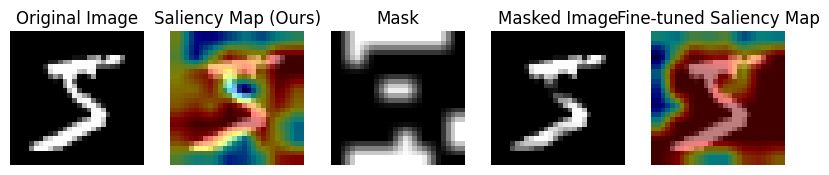

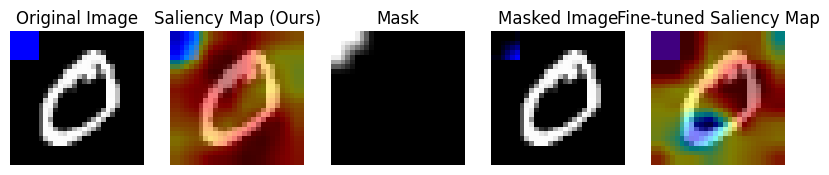

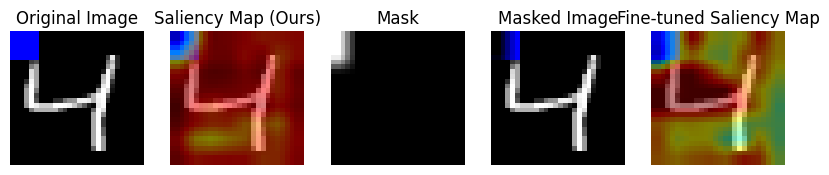

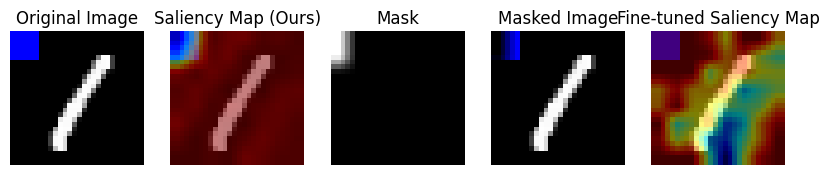

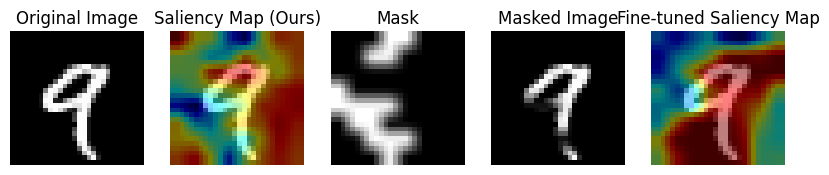

In [23]:
# Plot some saliency maps, masks, and masked images
for i in range(5):  # Plot the first 5 samples
    # generate_saliency_map_single(original_images[i], image_classes[i], torch.load('/content/data/MNIST/CNN_checkpoint_finetuned.pth'))
    plot_saliency_and_mask(
        original_images[i],
        saliency_maps[i],
        create_mask(saliency_maps[i], threshold=0.5),
        masked_images[i],
        generate_saliency_map_single(
            original_images[i],
            image_classes[i],
            torch.load('/content/data/MNIST/CNN_checkpoint_finetuned.pth')
            )
        )

TODO:
- call `plot_saliency_and_mask` after finetuning. so that I can output the activation map for the masked image too.
- modify masking method so it follows the paper more precisely.
- while running `generate_saliency_map`, sometimes RuntimeWarning: invalid value encountered in divide is encountered:
    <ipython-input-15-611cf68c253b>:3: RuntimeWarning: invalid value encountered in divide
  saliency_map_normalized = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))
- make repo public
